#Paquetes necesarios

In [1]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

Carga imagen y convierte a RGB

(4080, 3060, 3)


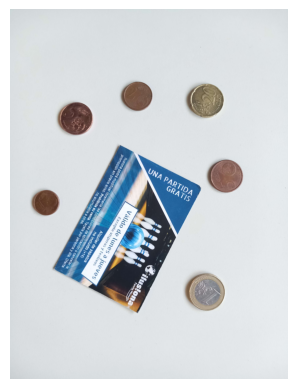

In [2]:
#Carga imagen ejemplo con monedas
img = cv2.imread('monedas_tarjeta.jpg') 
print(img.shape)
#Recordando que OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img_rgb) 
plt.show()

Convierte a gris y muestra histograma

(0.0, 256.0)

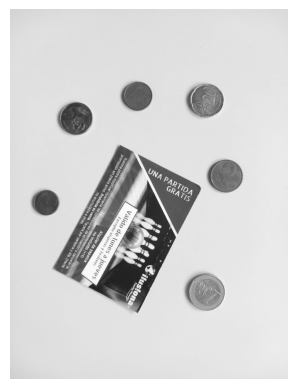

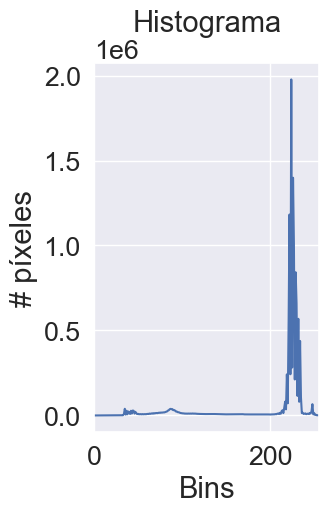

In [7]:
#Convierte la imagen a todos de gris, mostrando el resultado
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Cálculo del histograma con 256 bins de una imagen en escala de grises
hist = cv2.calcHist([img_gris], [0], None, [256], [0, 256])

plt.figure()
plt.axis("off")
plt.imshow(img_gris, cmap='gray')

# Histograma sin normalizar
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("# píxeles")
plt.plot(hist)
plt.xlim([0, 256])

Cuenta elementos tras umbralizar

Text(0.5, 1.0, 'OTSU invertida')

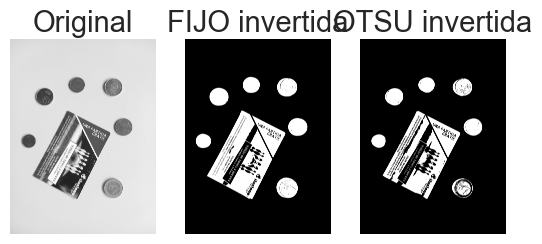

In [8]:
#Dos umbralizados. Te invito a probar con parámetros, aplicar filtro previo, etc.
umbral = 200
# Umbralizado binaria invertido, dado que por defecto se asume objetos en blanco
res,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
# Umbralizado con método de Otsu
ret2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')



Búsqueda de componentes y sus contornos

TAREA: Captura una o varias imágenes con monedas no solapadas y algún objeto que no lo sea. Filtra los contornos que no se correpondan con monedas, y muestra el número total de monedas presentes en la imagen.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


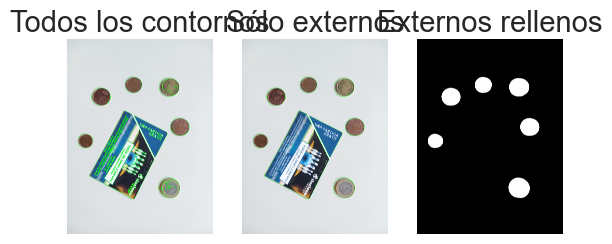

Número de monedas: 6


In [14]:
#Localiza contornos en imagen obtenida con umbral fijo
#findContours está diseñada para imágenes con la figura en blanco y el fondo negro
#La imagen de entrada debe ser de un canal y 8 bits excepto en los modos RETR_CCOMP o RETR_FLOODFILL
#hierarchy contiene información sobre el nivel del contorno, relaciones paterno-filiales

# Inicializa un contador para el número de objetos circulares
num_objetos_circulares = 0

# Define un umbral para considerar si un objeto es circular
umbral_circularidad = 0.9

#Obtiene todos los contornos, externos e internos
contornos, hierarchy = cv2.findContours(
    img_th1, #imagen
    cv2.RETR_TREE, #Modo de recuperación (lista, árbol, nivel superior)
    cv2.CHAIN_APPROX_SIMPLE #Método de aproximación del contorno
    )
#Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

# Dibuja sobre la imagen de entrada todos los contornos en verde
#Cada vez que quiere pintar convierte img para no tener restos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

# Dibuja sobre la imagen de entrada sólo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Sólo externos')

#Dibuja contornos externos rellenos en imagen vacía
#crea imagen vacíanegra
img_cont = np.zeros(img_rgb.shape)
for c in contornos2:
    #Área delcontorno
    area = cv2.contourArea(c)

    #Dimensión mínima (útil en ocasiones)
    if area > 10:
        #Perímetro delcontorno
        perimetro = cv2.arcLength(c,True)
        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        #Mínimo contenedor ajustado para el contorno
        rect = cv2.minAreaRect(c)
        #Mínimo círculo que lo contiene
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        #Elipse ajustada al contorno
        if c.shape[0] > 5:
            elipse = cv2.fitEllipse(c)
            #Para determinadas tareas nos interesará mostrar estos valores
            #print(area, perimetro, rect, cx,cy,radio, elipse)
    (cx, cy), radio = cv2.minEnclosingCircle(c)
    area_circulo = np.pi * (radio ** 2)
    
    # Calcula la circularidad como el área del contorno dividido por el área del círculo mínimo
    circularidad = area / area_circulo
    
    # Si la circularidad está por encima del umbral, consideramos el objeto como circular
    if circularidad >= umbral_circularidad:
        num_objetos_circulares += 1
        #Dibuja los contornos
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)

plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()
print(f"Número de monedas: {num_objetos_circulares}")


Una alternativa consiste en contar círculos utilizando la Transformada de Hough. La selección de parámetros puede ser "divertida", más [información](https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html)


TAREA: Captura una o varias imágenes con monedas no solapadas, y otras con monedas solapadas. Identificada una moneda de un euro en la imagen, por ejemplo con un clic de ratón, calcular la cantidad de dinero presente en la imagen. ¿Qué problemas han observado?


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


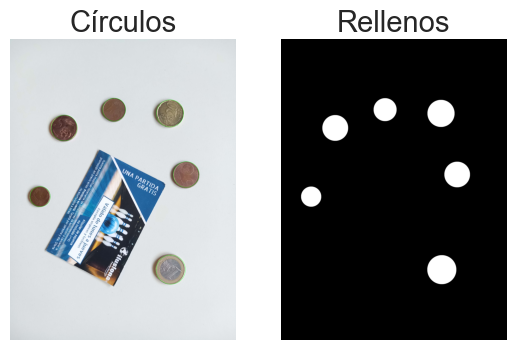

---------------------------------------
Cantidad de monedas
---------------------------------------
1 euro: 1 monedas
20 centimos: 1 monedas
2 centimos: 1 monedas
5 centimos: 2 monedas
1 centimo: 1 monedas
---------------------------------------
Total: 1.33 euros


In [15]:
#Conversión a gris
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suaviza altas frecuencias
pimg = cv2.medianBlur(gris, 7)
#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1.5,
        650,  # distancia mínima entre círculos
        param1=200, # Valor del gradiente
        param2=120, #Umbral acumulador
        minRadius=60,  # radio mínimo
        maxRadius=250,  # radio máximo
    )
coin_counters = {
    "1 euro": 0,
    "20 centimos": 0,
    "2 centimos": 0,
    "5 centimos": 0,
    "1 centimo": 0,
}
#Dibuja sobre entrada  e imagen vacía

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_cont = np.zeros(img_rgb.shape)
for det in circ[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)

# Inicializa una lista para almacenar las dimensiones de las monedas
coin_dimensions = []

for det in circ[0]:
    x_coor, y_coor, det_radio = det
    # Calcula el diámetro de la moneda (el doble del radio)
    diameter = round(2 * det_radio)
    # Calcula el área del círculo (pi * r^2)
    area = round(np.pi * (det_radio ** 2))
    coin_dimensions.append((diameter, area))
coin_dimensions.sort()
# Identifica las monedas y suma a los contadores
for dimension in coin_dimensions:
    if dimension == coin_dimensions[-1]:
        coin_counters["1 euro"] += 1
    elif dimension == coin_dimensions[-2]:
        coin_counters["20 centimos"] += 1
    elif dimension == coin_dimensions[1]:
        coin_counters["2 centimos"] += 1
    elif dimension == coin_dimensions[0]:
        coin_counters["1 centimo"] += 1
    else:
        coin_counters["5 centimos"] += 1




#Muestra resultado
plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Círculos')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Rellenos')

plt.show()

# Define la función para manejar el evento del clic
def on_mouse_click(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print("---------------------------------------")
        print("Cantidad de monedas")
        print("---------------------------------------")
        # Imprime los resultados
        for coin, count in coin_counters.items():
            print(f"{coin}: {count} monedas")
        total = (
            coin_counters["1 euro"] +
            coin_counters["1 centimo"] * 0.01 +
            coin_counters["2 centimos"] * 0.02 +
            coin_counters["5 centimos"] * 0.05 +
            coin_counters["20 centimos"] * 0.20
        )
        print("---------------------------------------")
        print("Total: " + str(total) + " euros")

# Redimensiona la imagen para que se ajuste a la ventana
window_size = (800, 600)  
img_rgb_resized = cv2.resize(img_rgb, window_size)

# Muestra la imagen y espera a que se haga clic
cv2.imshow('Imagen con Círculos', img_rgb_resized)

# Configura el manejador de eventos de clic en la ventana
cv2.setMouseCallback('Imagen con Círculos', on_mouse_click)

while True:
    if cv2.waitKey(1) & 0xFF == 27:  # Presiona la tecla Esc (27 en ASCII) para salir
        break

cv2.destroyAllWindows()


Clasificación de microplásticos

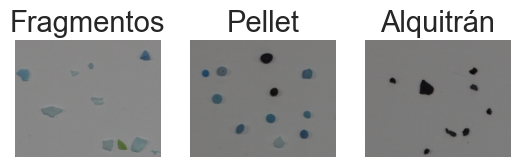

In [16]:
#Cargamos tres subimágenes de cada uno de los tres tipos considerados (el alquitrán efectivamenet no es microplástico)
imgF = cv2.imread('FRA.png') 
imgP = cv2.imread('PEL.png') 
imgT = cv2.imread('TAR.png') 

#Mostramos
plt.subplot(131)
plt.axis("off")
plt.imshow(imgF) 
plt.title('Fragmentos')
plt.subplot(132)
plt.axis("off")
plt.imshow(imgP) 
plt.title('Pellet')
plt.subplot(133)
plt.axis("off")
plt.imshow(imgT) 
plt.title('Alquitrán')
plt.show()

TAREA: Estas tres imágenes han sido extraidas de las imágenes de mayor tamaño contenidas en la carpeta. Determina patrones geométricos para cada una de las tres clases y evalúa los aciertos y fallos con las imágenes completas la matriz de confusión. Para cada clase, determina el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifica incorrectamente por cada una de las otras dos clases.

El el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas en dicho trabajo fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación del cuadrado del perímetro con el área)
- Relación del área con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

Las métricas se utilizan para mostrar la bondad de un clasificador, la siguiente celda obtiene varias para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador par alas distintas clases consideradas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


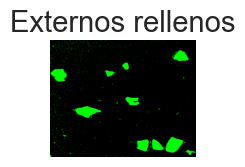

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


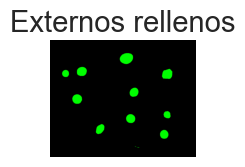

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


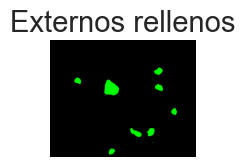

In [17]:
import cv2
import numpy as np

def prueba_imagen(imagen):
    # Convertir la imagen a escala de grises
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    # Definir un valor de umbral
    if(imagen == fra).all():
        umbral = 131.75
    else:
        umbral = 90
    # Aplicar umbral a la imagen en escala de grises
    _, img_th1 = cv2.threshold(imagen_gris, umbral, 255, cv2.THRESH_BINARY_INV)
    
    # Encontrar contornos en la imagen binarizada
    contornos, _ = cv2.findContours(imagen_gris, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
 #Obtiene únicamente los contornos externos
    contornos2, hierarchy2 = cv2.findContours(img_th1, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
    
    img_rgb = cv2.cvtColor(imagen , cv2.COLOR_BGR2RGB)
    img_cont = np.zeros(img_rgb.shape)
    img_cont = np.zeros(img_rgb.shape)

    for c in contornos2:
            #Área delcontorno
        cv2.drawContours(img_cont, [c], -1, (0,255,0), -1)
        area_flag = cv2.contourArea(c)
  
    plt.subplot(133)
    plt.axis("off")
    plt.imshow(img_cont) 
    plt.title('Externos rellenos')
    plt.show()
    

# Cargar imágenes
pel = cv2.imread("PEL.png")
tar = cv2.imread("TAR.png")
fra = cv2.imread("FRA.png")

# Calcular los patrones promedio para cada imagen
patron_fragmentos = prueba_imagen(fra)
patron_pellet = prueba_imagen(pel)
patron_alquitran = prueba_imagen(tar)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


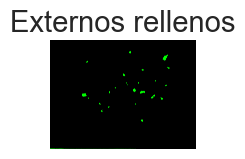

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


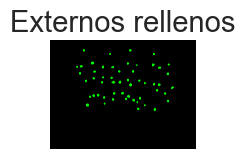

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


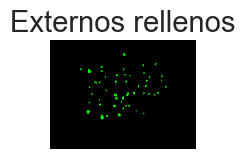

[22, 1, 2]
[6, 44, 3]
[2, 0, 48]


In [18]:
import cv2
import numpy as np

def recuento_patrones(imagen, umbral):
    # Convertir la imagen a escala de grises
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Aplicar umbral a la imagen en escala de grises
    _, img_th1 = cv2.threshold(imagen_gris, umbral, 255, cv2.THRESH_BINARY_INV)
    
    # Encontrar contornos en la imagen binarizada
    contornos, _ = cv2.findContours(imagen_gris, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    #Obtiene únicamente los contornos externos
    contornos2, hierarchy2 = cv2.findContours(img_th1, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)


    cont_alquitran = 0
    cont_fragmentos = 0
    cont_prellet = 0
    
    def is_blackish(color):
        # Establece un umbral para los componentes B, G y R
        threshold = 30  
        return all(value <= threshold for value in color)
    

    #Dibuja contornos externos rellenos en imagen vacía
    #crea imagen vacíanegra
    img_rgb = cv2.cvtColor(imagen , cv2.COLOR_BGR2RGB)
    img_cont = np.zeros(img_rgb.shape)
    img_cont = np.zeros(img_rgb.shape)
    
    for contorno in contornos2:

        # Calcular el área
        area = cv2.contourArea(contorno)
        if(area<20000 and area>1000):
            
            cv2.drawContours(img_cont, [contorno], -1, (0,255,0), -1)
            (cx, cy), radio = cv2.minEnclosingCircle(contorno)
            area_circulo = np.pi * (radio ** 2)
                
            # Calcula la circularidad como el área del contorno dividido por el área del círculo mínimo
            circularidad = area / area_circulo
            #Define una función para verificar si un color es negro o similar al negro

            M = cv2.moments(contorno)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                
                # Obtiene el color del píxel en el centro del contorno
                color = img_rgb[cY, cX]

            # Verifica si el color es negro o similar al negro
            if is_blackish(color):
                cont_alquitran += 1
            elif(circularidad>0.7):
                cont_prellet +=1
            else:
                cont_fragmentos+=1

        
    plt.subplot(133)
    plt.axis("off")
    plt.imshow(img_cont) 
    plt.title('Externos rellenos')
    plt.show()

    recuento = [cont_fragmentos, cont_prellet, cont_alquitran]

    
    return recuento

# Cargar imágenes
fra = cv2.imread("fragment-03-olympus-10-01-2020.JPG")
pel = cv2.imread("pellet-03-olympus-10-01-2020.JPG")
tar = cv2.imread("tar-03-olympus-10-01-2020.JPG")

# Definir un valor de umbral
umbral = 100

# Calcular los patrones promedio para cada imagen
recuento_fragmentos = recuento_patrones(fra, umbral)
recuento_pellet = recuento_patrones(pel, umbral)
recuento_alquitran = recuento_patrones(tar, umbral)

print(recuento_fragmentos)
print(recuento_pellet)
print(recuento_alquitran)



Accuracy (TP/(n))= 0.8888888888888888
Precision (TP/(TP+FP)) = 0.6666666666666666
Recall (TP/(TP+FN)) = 0.8888888888888888
F1 Score (2*(precision*recall)/(precision+recall)) = 0.19047619047619047


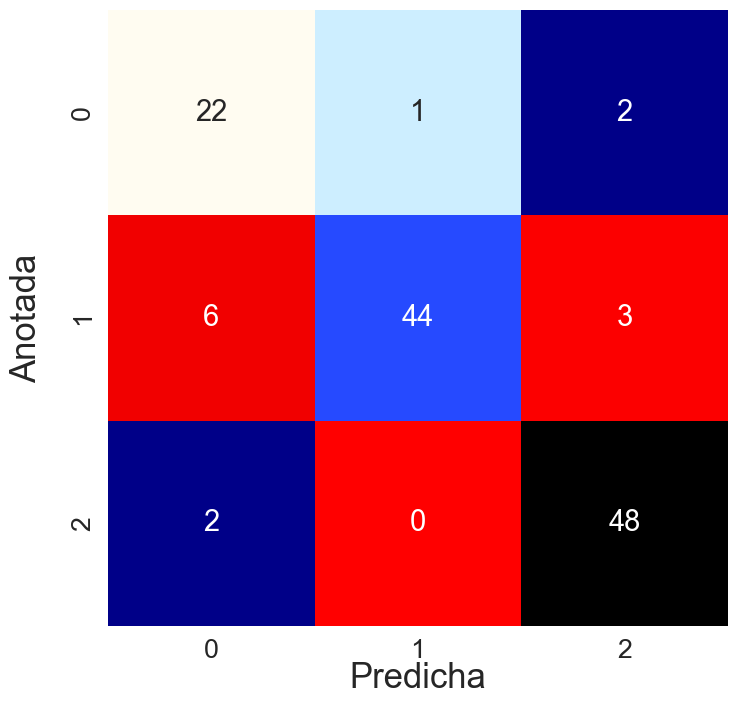

In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
# Unir los vectores en uno solo
y_pred = np.concatenate((recuento_fragmentos, recuento_pellet, recuento_alquitran))


y = [25,0,0,0,52,0,0,0,50]


accuracy = accuracy_score(y, y_pred)
#Para más de una clase se define la forma de promediar
precision = precision_score(y, y_pred,average='weighted', zero_division=0)
recall = recall_score(y, y_pred,average='weighted', zero_division=0)
f1score = f1_score(y, y_pred,average='weighted', zero_division=0)

print(f"Accuracy (TP/(n))= {1-accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {1-recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")

# Crear la matriz de confusión
conf_matrix = np.array(y_pred).reshape(3, 3)

# Crear una figura de matplotlib
plt.figure(figsize=(8, 8))

# Crear la matriz de confusión usando Seaborn
sns.set(font_scale=1.75)
ax = sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cbar=False,
    cmap='flag'
)

# Etiquetas de la matriz de confusión
label_font = {'size': '25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Anotada", labelpad=20, fontdict=label_font)

plt.show()


[1, 0, 2, 1, 2, 0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 1, 2, 2, 0, 0, 1, 2, 2, 0, 0, 1, 2, 0, 0, 2, 2, 2, 1, 2, 2, 1, 0, 2, 2, 1, 1, 0, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 0, 2, 2, 2, 1, 0, 2, 0, 2, 0, 1, 0, 0, 2, 1, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 0, 2, 2, 0, 0, 1, 1, 1, 2, 0, 1, 2]
Accuracy (TP/(n))= 0.35
Precision (TP/(TP+FP)) = 0.3498958333333333
Recall (TP/(TP+FN)) = 0.35
F1 Score (2*(precision*recall)/(precision+recall)) = 0.34989575929874434


Text(38.25, 0.5, 'Anotada')

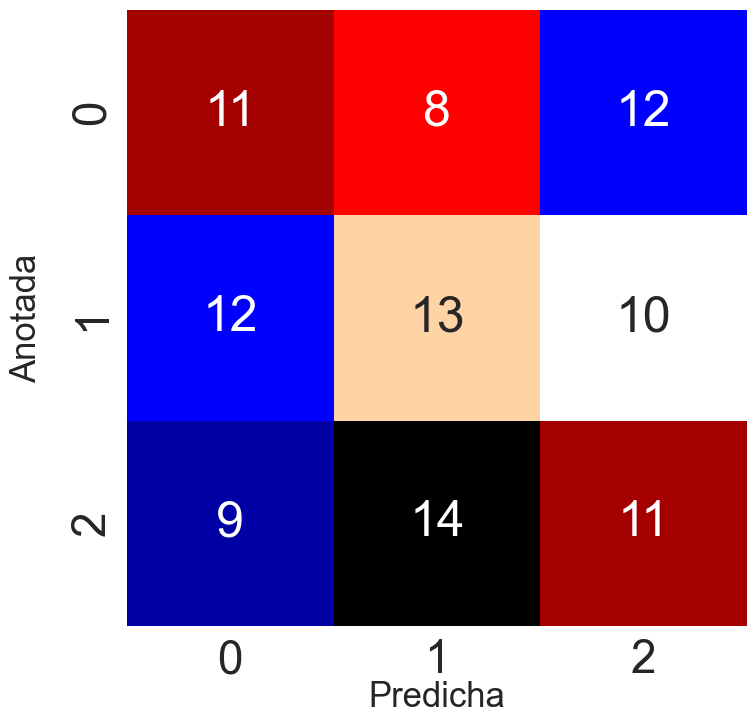

In [90]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


# Numero de muestras
n =  100
nclases = 3

# A falta de clasificador y conjunto de datos, creamos anotaciones y predicciones de forma aleatoria
# Vector aleatorio con etiquetas anotadas
y = [random.randint(0, nclases - 1) for _ in range(n)]
print(y)
# Vector aleatorio con etiquetas predichas por un supuesto clasificador
y_pred = [random.randint(0, nclases - 1) for _ in range(n)]


accuracy = accuracy_score(y, y_pred)
#Para más de una clase se define la forma de promediar
precision = precision_score(y, y_pred,average='weighted')
recall = recall_score(y, y_pred,average='weighted')
f1score = f1_score(y, y_pred,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Anotada", labelpad=20, fontdict=label_font)
